<a href="https://colab.research.google.com/github/AkiHora/Mammography-problems/blob/main/MaskOfBreast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import pandas as pd
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_name = 'Train.rar'
if not os.path.exists(file_name):
    url = 'https://drive.google.com/file/d/18gehyYOPB7jOgoqbDsxeN5leAzfjkBYE/view?usp=sharing'
    downloaded = drive.CreateFile({'id': url.split('/d/')[-1].split('/view')[0]})   # replace the id with id of file you want to access
    downloaded.GetContentFile(file_name)        # replace the file name with your file

In [ ]:
!pip install patool
import patoolib
patoolib.extract_archive("Train.rar", outdir="/content")

     |████████████████████████████████| 81kB 5.2MB/s 
patool: Extracting Train.rar ...
patool: running /usr/bin/unrar x -- /content/Train.rar
patool:     with cwd='/content'
patool: ... Train.rar extracted to `/content'.


'/content'

In [ ]:
from PIL import Image

from glob import glob
img_path = 'Train/input/'

X_train_paths = glob(img_path + '???.png') + glob(img_path + '??.png')
y_train_paths = glob(img_path + '*mask.png')

X_train_paths.sort()
y_train_paths.sort()

from tqdm import tqdm
import numpy as np

X = []
y = []
N = len(X_train_paths)
shape = (224, 224)
with tqdm(total=N) as pbar:
  for x_path, y_path in zip(X_train_paths[:N], y_train_paths[:N]):
    
    im = Image.open(x_path)
    im = im.resize((224, 224))
    img_array = np.asarray(im)
    img_array = img_array.reshape(224, 224, 1)/255
    img_array = np.concatenate([img_array]*3, axis=-1)

    X.append(img_array)

    im = Image.open(y_path)
    im = im.resize(shape)
    img_array = np.asarray(im)
    img_array = (img_array > 127).astype(int)
    img_array = img_array.reshape(224, 224, 1)
    y.append(img_array)
    pbar.update()

X = np.array(X)
y = np.array(y)

100%|██████████| 474/474 [00:12<00:00, 38.38it/s]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from keras.layers import Input, Dense, Concatenate, Conv2D, Activation, MaxPooling2D, UpSampling2D
from keras import Model

inp = Input(shape=(224, 224, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_2_2)
conc_4 = Concatenate()([conv_1_2, up_4])
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
result = Activation('sigmoid')(conv_up_4_2)

model = Model(inputs=inp, outputs=result)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 224, 224, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 224, 224, 32) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 224, 224, 32) 9248        activation_6[0][0]               
____________________________________________________________________________________________

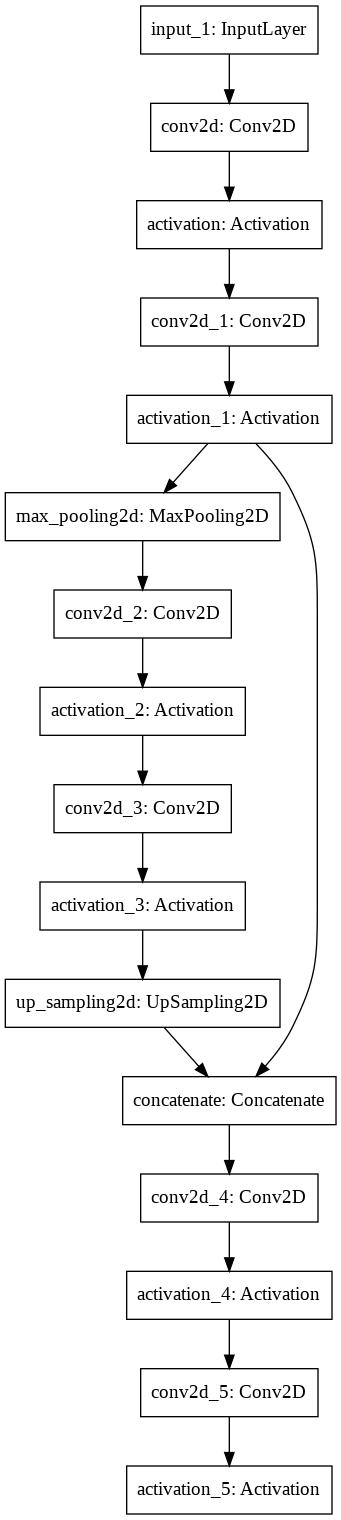

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [ ]:
import keras

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)
model.compile(adam, 'binary_crossentropy', metrics=['accuracy',])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
23/23 [==============================] - 4s 136ms/step - loss: 0.6713 - accuracy: 0.7490 - val_loss: 0.5936 - val_accuracy: 0.8737
Epoch 2/20
23/23 [==============================] - 3s 118ms/step - loss: 0.5765 - accuracy: 0.9016 - val_loss: 0.4749 - val_accuracy: 0.9472
Epoch 3/20
23/23 [==============================] - 3s 119ms/step - loss: 0.4608 - accuracy: 0.9680 - val_loss: 0.3371 - val_accuracy: 0.9725
Epoch 4/20
23/23 [==============================] - 3s 119ms/step - loss: 0.2762 - accuracy: 0.9750 - val_loss: 0.1282 - val_accuracy: 0.9718
Epoch 5/20
23/23 [==============================] - 3s 121ms/step - loss: 0.0887 - accuracy: 0.9761 - val_loss: 0.0956 - val_accuracy: 0.9742
Epoch 6/20
23/23 [==============================] - 3s 120ms/step - loss: 0.0703 - accuracy: 0.9788 - val_loss: 0.0841 - val_accuracy: 0.9777
Epoch 7/20
23/23 [==============================] - 3s 120ms/step - loss: 0.0533 - accuracy: 0.9834 - val_loss: 0.0809 - val_accuracy: 0.9780
Epoch 

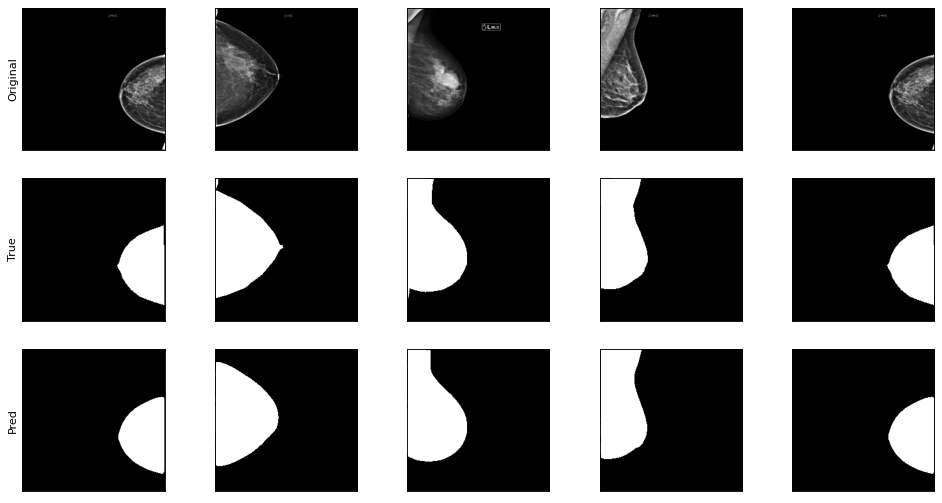

In [ ]:
import matplotlib.pyplot as plt


def show_results(net, X, y, cols = 5):
  rand_idxs = np.random.randint(0, len(y), size=cols)
  plt.figure(figsize=(15, 8), dpi=80)
  preds = net(X[rand_idxs])

  for col in range(1, cols+1):
    ax = plt.subplot(3, cols, col, xticks=[], yticks=[])
    if col == 1:
      ax.set_ylabel('Original')
    ax.imshow(X[rand_idxs[col-1]])

  for col in range(1, cols+1):
    ax = plt.subplot(3, cols, col + cols, xticks=[], yticks=[])
    if col == 1:
      ax.set_ylabel('True')
    ax.imshow(y[rand_idxs[col-1]][:, :, 0], cmap='gray', )

  for col in range(1, cols+1):
    ax = plt.subplot(3, cols, col + 2*cols, xticks=[], yticks=[])
    if col == 1:
      ax.set_ylabel('Pred')
    ax.imshow(preds[col-1][:, :, 0] > 0.5, cmap='gray')

  plt.show()

show_results(model, X_test, y_test)

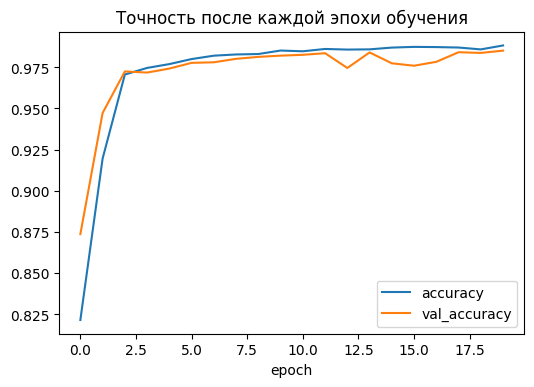

In [ ]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Точность после каждой эпохи обучения')
plt.xlabel('epoch')
plt.legend()
plt.show()

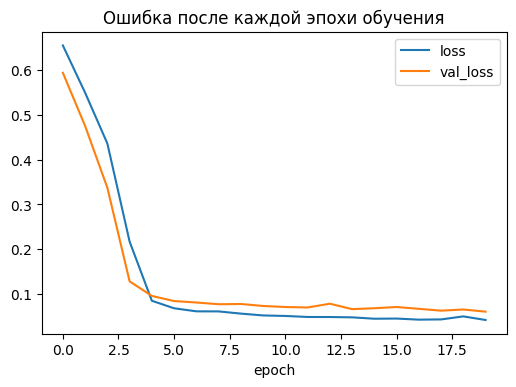

In [ ]:
plt.figure(dpi=100)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Ошибка после каждой эпохи обучения')
plt.xlabel('epoch')
plt.legend()
plt.show()